# Fine-tuning Amazon Nova Lite with Vision Capabilities - Model Training and Inference

## Introduction

In this notebook, we'll use the data prepared in the previous notebook to fine-tune an Amazon Nova Lite multi-modal model using Amazon Bedrock. After fine-tuning, we'll test the model's performance using the test dataset.

## Setup

First, let's install and import the necessary libraries:

In [1]:
import boto3
import os
import json
import time
import base64
import io
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set AWS region
region = "us-east-1"  # Nova Lite fine-tuning is available in this region

# Create AWS clients
session = boto3.session.Session(region_name=region)
s3_client = session.client('s3')
bedrock = session.client(service_name="bedrock", region_name=region)
bedrock_runtime = session.client(service_name="bedrock-runtime", region_name=region)

In [3]:
# # Retrieve stored variables from previous notebook
# %store -r bucket_name
# %store -r train_data_uri
# %store -r validation_data_uri
# %store -r test_data_uri
# %store -r role_arn
# %store -r role_name
# %store -r policy_arn
# %store -r text_prompt
# %store -r test_s3_paths
# %store -r account_id

bucket_name = "sagemaker-us-east-1-452145973879"
train_data_uri = "s3://sagemaker-us-east-1-452145973879/projects/nova-image-tagging/data/merged_data/v1/nova_sft_trainset.jsonl"
validation_data_uri =  "s3://sagemaker-us-east-1-452145973879/projects/nova-image-tagging/data/merged_data/v1/nova_sft_testset.jsonl"
role_arn = "arn:aws:iam::452145973879:role/service-role/bedrock-finetune"

print(f"Bucket name: {bucket_name}")
print(f"Training data URI: {train_data_uri}")
print(f"Validation data URI: {validation_data_uri}")
print(f"Role ARN: {role_arn}")

Bucket name: sagemaker-us-east-1-452145973879
Training data URI: s3://sagemaker-us-east-1-452145973879/projects/nova-image-tagging/data/merged_data/v1/nova_sft_trainset.jsonl
Validation data URI: s3://sagemaker-us-east-1-452145973879/projects/nova-image-tagging/data/merged_data/v1/nova_sft_testset.jsonl
Role ARN: arn:aws:iam::452145973879:role/service-role/bedrock-finetune


## Create Fine-tuning Job

Now, we'll create a fine-tuning job for the Amazon Nova Lite multi-modal model:

In [4]:
nova_lite_base_model_arn = "arn:aws:bedrock:us-east-1::foundation-model/amazon.nova-lite-v1:0:300k"

In [5]:
# Generate a timestamp for unique naming
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S")

# Define job parameters
job_name = f"nova-multimodal-ft-{timestamp}"
custom_model_name = f"nova-multimodel-{timestamp}"

# Define hyperparameters
hyperparameters = {
    "epochCount": "2",       # Number of training epochs
    "batchSize": "1",        # Batch size for training
    "learningRate": "0.00001"  # Learning rate
}

# Define output location
output_s3_uri = f"s3://{bucket_name}/output/"

# Create validation data config
validation_data_config = {
    "validators": [{
        "s3Uri": validation_data_uri
    }]
}

In [6]:
# Create fine-tuning job
try:
    response = bedrock.create_model_customization_job(
        customizationType="FINE_TUNING",
        jobName=job_name,
        customModelName=custom_model_name,
        roleArn=role_arn,
        baseModelIdentifier=nova_lite_base_model_arn,
        hyperParameters=hyperparameters,
        trainingDataConfig={"s3Uri": train_data_uri},
        # validationDataConfig=validation_data_config,
        outputDataConfig={"s3Uri": output_s3_uri}
    )
    
    # Get job identifier
    job_arn = response["jobArn"]
    print(f"Fine-tuning job created: {job_arn}")
    
except Exception as e:
    print(f"Error creating fine-tuning job: {e}")

Fine-tuning job created: arn:aws:bedrock:us-east-1:452145973879:model-customization-job/amazon.nova-lite-v1:0:300k/miee4df3g2vt


## Monitor Job Status

Let's monitor the status of our fine-tuning job:

<div style="
    background-color: #fcf8e3; 
    color: #8a6d3b;
    padding: 15px;
    margin-bottom: 20px;
    border: 1px solid #faebcc;
    border-radius: 4px;
    font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;">
    <span style="font-weight:bold;">⚠️ Warning:</span> 
    <p>Fine-tuning jobs for Amazon Nova Lite multi-modal models may take <b>several hours to complete</b>. 
    The exact duration depends on your dataset size, model parameters, and current training resource availability.</p>
</div>

In [21]:
# Function to check job status
def check_job_status(job_arn):
    response = bedrock.get_model_customization_job(jobIdentifier=job_arn)
    return response["status"]

# Get current job status
current_status = check_job_status(job_arn)
print(f"Current job status: {current_status}")

# If job completed successfully, get the model details
if current_status == "Completed":
    model_details = bedrock.get_model_customization_job(jobIdentifier=job_arn)
    custom_model_arn = model_details["outputModelArn"]
    print(f"Fine-tuned model ARN: {custom_model_arn}")

Current job status: InProgress


## Visualize Training Metrics

Let's download and visualize the training metrics:

<div style="
    background-color: #fcf8e3; 
    color: #8a6d3b;
    padding: 15px;
    margin-bottom: 20px;
    border: 1px solid #faebcc;
    border-radius: 4px;
    font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;">
    <span style="font-weight:bold;">⚠️ Warning:</span> 
    <p>Please ensure the status is <b>"Completed"</b> before proceeding with the following cells. 
    You can re-run the status check cell above to update this status.</p>
</div>

In [ ]:
# Download training metrics from S3
def download_metrics(split="train"):
    # Get the job ID from the ARN
    job_id = job_arn.split('/')[-1]
    # job_id = "tc0u5mpsw7ge"
    
    # Define file paths
    if split == 'train':
        train_metrics_s3_key = f"output/model-customization-job-{job_id}/training_artifacts/step_wise_training_metrics.csv"
    else:
        train_metrics_s3_key = f"output/model-customization-job-{job_id}/validation_artifacts/post_fine_tuning_validation/validation/validation_metrics.csv"

    local_train_metrics = f"{split}_metrics.csv"
    
    # Download files
    try:
        s3_client.download_file(bucket_name, train_metrics_s3_key, local_train_metrics)
        
        print("Metrics downloaded successfully")
        return local_train_metrics
        
    except Exception as e:
        print(f"Error downloading metrics: {e}")
        return None, None

Metrics downloaded successfully


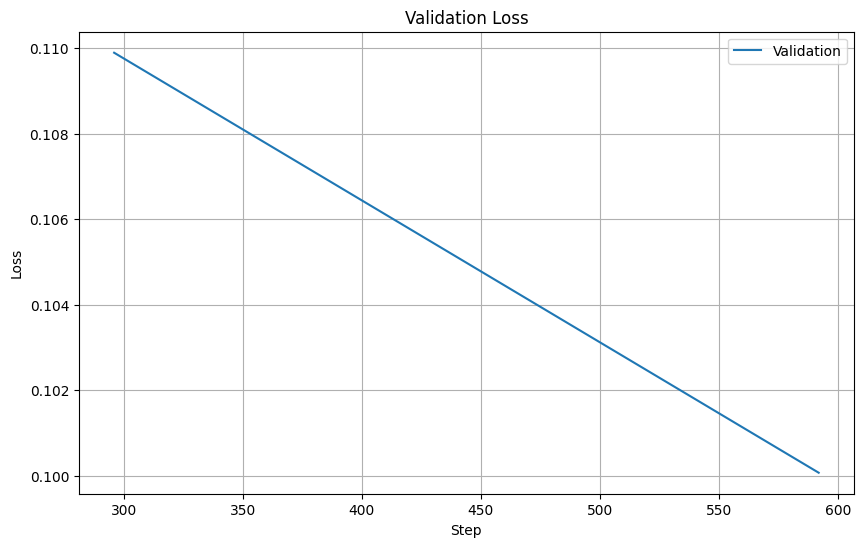

In [19]:
# Download metrics 
split = "validation" # "validation"

train_metrics_file = download_metrics(split)

# Plot training and validation loss if metrics are available
if train_metrics_file:
    import pandas as pd
    
    # Load metrics
    train_data = pd.read_csv(train_metrics_file)

    # Calculate step-level training loss
    train_metrics_epoch = train_data.groupby('step_number').mean()
    
    # Plot
    plt.figure(figsize=(10, 6))
    if split == 'train':
        plt.plot(train_metrics_epoch.index, train_metrics_epoch.training_loss, label='Training')
        plt.title('Training Loss')
    else:
        plt.plot(train_metrics_epoch.index, train_metrics_epoch.validation_loss, label='Validation')
        plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.legend()
    plt.grid(True)
    plt.show()

## Deploy the fine-tuned model

We'll deploy the fine-tuned model with [On-demand inference option](https://docs.aws.amazon.com/nova/latest/userguide/custom-fine-tune-odi.html). 

On-demand (OD) inference allows you to run inference on your custom Amazon Nova models without maintaining provisioned throughput endpoints. This helps you optimize costs and scale efficiently. With On-demand inference, you are charged based on usage, measured in tokens, both in and out.

In [11]:
# Function to check deployment status
def check_deployment_status(deployment_arn):
    """
    Check the status of a custom model deployment
    
    Parameters:
    -----------
    deployment_arn : str
        ARN of the deployment to check
        
    Returns:
    --------
    status : str
        Current status of the deployment
    """
    try:
        response = bedrock.get_custom_model_deployment(
            customModelDeploymentIdentifier=deployment_arn
        )
        status = response.get('status')
        print(f"Deployment status: {status}")
        return status
    
    except Exception as e:
        print(f"Error checking deployment status: {e}")
        return None

In [ ]:
# Function to create on-demand inferencing deployment for custom model
def create_model_deployment(custom_model_arn):
    """
    Create an on-demand inferencing deployment for the custom model
    
    Parameters:
    -----------
    custom_model_arn : str
        ARN of the custom model to deploy
        
    Returns:
    --------
    deployment_arn : str
        ARN of the created deployment
    """
    try:
        print(f"Creating on-demand inferencing deployment for model: {custom_model_arn}")
        
        # Generate a unique name for the deployment
        deployment_name = f"nova-deployment-{time.strftime('%Y%m%d-%H%M%S')}"
        
        # Create the deployment
        response = bedrock.create_custom_model_deployment(
            modelArn=custom_model_arn,
            modelDeploymentName=deployment_name,
            description=f"on-demand inferencing deployment for model: {custom_model_arn}",
        )
        
        # Get the deployment ARN
        deployment_arn = response.get('customModelDeploymentArn')
        
        print(f"Deployment request submitted. Deployment ARN: {deployment_arn}")
        return deployment_arn
    
    except Exception as e:
        print(f"Error creating deployment: {e}")
        return None

In [ ]:
# If job completed successfully, get the model details and create deployment
if current_status == "Completed":
    # Get custom model ARN
    model_details = bedrock.get_model_customization_job(jobIdentifier=job_arn)
    custom_model_arn = model_details["outputModelArn"]
    print(f"Fine-tuned model ARN: {custom_model_arn}")
    
    # Create on-demand deployment
    deployment_arn = create_model_deployment(custom_model_arn)
    
    if deployment_arn:
        # Check initial status
        initial_status = check_deployment_status(deployment_arn)
        
        # Store the deployment ARN for later use
        %store deployment_arn

## Wait for Deployment to Complete

ℹ️ **Info:** It takes about 30 mins to complete the deployment

Let's monitor our deployment until it's ready for use:

In [ ]:
# Function to wait for deployment to be ready
def wait_for_deployment(deployment_arn, max_wait_seconds=3600, check_interval=60):
    """
    Wait for a deployment to reach 'IN_SERVICE' status
    
    Parameters:
    -----------
    deployment_arn : str
        ARN of the deployment to monitor
    max_wait_seconds : int
        Maximum wait time in seconds (default: 1800s = 30 minutes)
    check_interval : int
        Interval between checks in seconds (default: 60s)
        
    Returns:
    --------
    success : bool
        True if deployment is in service, False otherwise
    """
    import time
    from tqdm.notebook import tqdm
    
    start_time = time.time()
    end_time = start_time + max_wait_seconds
    
    print(f"Waiting for deployment to complete (max wait time: {max_wait_seconds/60:.1f} minutes)")
    
    # Create a progress bar for the wait time
    with tqdm(total=max_wait_seconds, desc="Waiting for deployment", unit="sec") as pbar:
        elapsed = 0
        while time.time() < end_time:
            status = check_deployment_status(deployment_arn)
            
            if status == "Active":
                print(f"\n✅ Deployment is now in service after {(time.time() - start_time)/60:.1f} minutes")
                return True
                
            if status == "Failed":
                print(f"\n❌ Deployment failed or was deleted. Final status: {status}")
                return False
                
            # Update progress bar with time elapsed since last check
            new_elapsed = int(time.time() - start_time)
            pbar.update(new_elapsed - elapsed)
            elapsed = new_elapsed
            
            # Wait before checking again
            time.sleep(check_interval)
    
    print(f"\n⚠️ Timed out after waiting {max_wait_seconds/60:.1f} minutes. Deployment may still be in progress.")
    return False

# Only attempt to wait for deployment if it was created
if 'deployment_arn' in locals() and deployment_arn:
    deployment_ready = wait_for_deployment(deployment_arn)
    
    if deployment_ready:
        %store deployment_arn
    else:
        print("Deployment did not complete successfully. Using the base custom model for inference.")

## Test with Inference

Now, let's test our fine-tuned model using the test dataset:

In [ ]:
def process_w2(s3_uri):

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "image": {
                    "format": "png",
                    "source": {
                        "s3Location": {
                            "uri": s3_uri,
                            "bucketOwner" : account_id
                        }
                    }
                    }
                },
                {
                    "text": text_prompt

                }
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"text": "```json"}
            ]
        }
    ]
    return messages

In [ ]:
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")
response = bedrock_client.converse(
            modelId=deployment_arn,
            messages=process_w2(test_s3_paths[0].get("s3_uri")),
            inferenceConfig={"maxTokens": 2048, "temperature": 0.0, "topP": 0.1, "stopSequences": ["```"]},
        )

In [ ]:
prediction = json.loads(response["output"]["message"]["content"][0]["text"].replace("```", ""))
prediction

In [ ]:
# Store variables for the next notebook
%store deployment_arn

print("Variables saved for use in the next notebook")

## Conclusion

In this notebook, we successfully fine-tuned an Amazon Nova Lite multi-modal model using Amazon Bedrock. We:

- Set up and launched a fine-tuning job with our prepared dataset
- Monitored the job progress and visualized training metrics
- Created provisioned throughput for the fine-tuned model
- Tested the model's performance with inference on test samples
- Cleaned up resources we no longer needed

The fine-tuned model can now answer questions about images based on the patterns it learned from our training data. For real-world applications, you may want to use a larger and more diverse dataset tailored to your specific use case.